<a href="https://colab.research.google.com/github/akshatagg06/credit-card-fraud-detect/blob/main/credit_card_fraud_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Import the libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

from imblearn.under_sampling import RandomUnderSampler

from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

### Import CSV

In [20]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# import file into a dataframe

df_fraud = pd.read_csv(file_path)

## Exploratory Analysis

First let's take a look at the data set and see how the PLC transformation has provided the data anonimity.

In [21]:
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Now let's examine some statistical elements and check if there are missing values.

In [22]:
# basic statistical details
df_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [23]:
# check for missing values
print('Number of missing data:', df_fraud.isnull().sum().max())

Number of missing data: 0


let's visualize the discrepancy in our dataset.

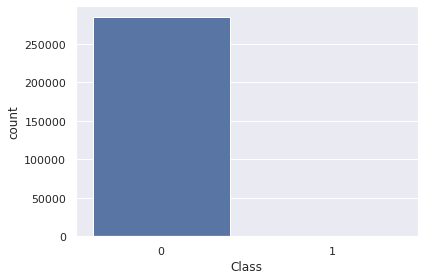

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

ax = sns.countplot(x='Class', data=df_fraud)
plt.tight_layout()
plt.savefig('graph1.png')

In [25]:
print(df_fraud['Class'].value_counts())
print('\nPercentage of fraudulent activity: {:.2%}'.format((df_fraud[df_fraud['Class'] == 1].shape[0] / df_fraud.shape[0])))

0    284315
1       492
Name: Class, dtype: int64

Percentage of fraudulent activity: 0.17%


let's examine the distribution of regular and fraudulent transactions over time.

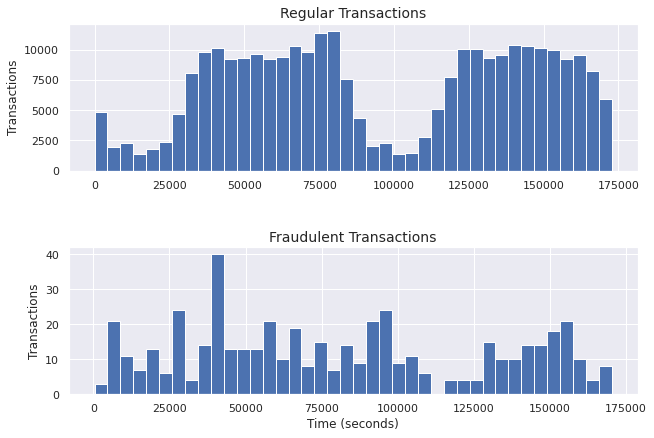

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].hist(df_fraud['Time'][df_fraud['Class'] == 0], bins=40)
ax[0].set_title('Regular Transactions', fontsize=14)
ax[0].set_ylabel('Transactions')

ax[1].hist(df_fraud['Time'][df_fraud['Class'] == 1], bins=40)
ax[1].set_title('Fraudulent Transactions', fontsize=14)
ax[1].set_ylabel('Transactions')
ax[1].set_xlabel('Time (seconds)')

plt.tight_layout(pad=4.0)
plt.savefig('graph2.png')

Although the number of frauds is significantly smaller than the number of regular transactions, we can see a distinct behavior, especially around the 100,000 Time mark.

Notice that the number of regular transactions drops sharply around the 90,000th second mark, to surge again around the 110,000th second mark. It wouldn't be absurd to assume that this period is during the night when individuals naturally perform fewer purchases and transactions than during the daytime. On the other hand, a great number of fraudulent transactions occurred around the 100,000 mark, which could confirm the previous assumption, considering that criminals should prefer to commit fraud late at night, assuming there would be less surveillance.

Of course, this is just a hypothesis. Let's wait and see how our machine learning model will interpret these numbers.

We can do the same analysis with the Amount of each transaction.

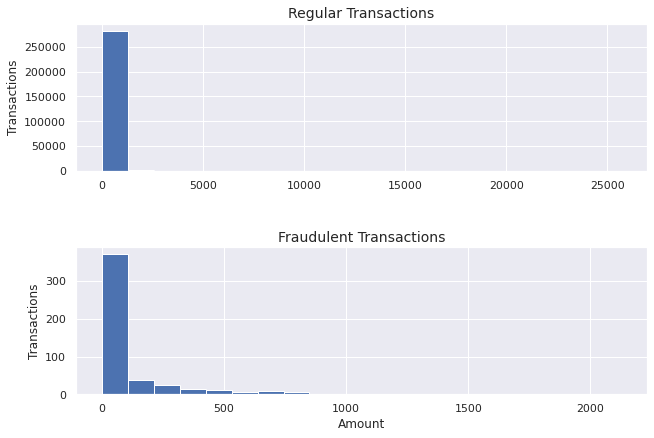

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].hist(df_fraud['Amount'][df_fraud['Class'] == 0], bins=20)
ax[0].set_title('Regular Transactions', fontsize=14)
ax[0].set_ylabel('Transactions')

ax[1].hist(df_fraud['Amount'][df_fraud['Class'] == 1], bins=20)
ax[1].set_title('Fraudulent Transactions', fontsize=14)
ax[1].set_ylabel('Transactions')
ax[1].set_xlabel('Amount')

plt.tight_layout(pad=4.0)
plt.savefig('graph3.png')

As for the transactions' amount, apparently there is no significant insight we can gather from them. Most transactions, both regular and fraudulent, were of "small" values. As we saw earlier, the majority of the transactions were of less than \$100,00.

#Machine Learning Models
Before setting up the machine learning model, we need to follow three steps:


*   Preprocess the features Time and Amount with StandardScaler
*   Split the dataset into train and test data
*   Deal with the unbalanced dataset



###Preprocessing
This is a crucial step in that the data is transformed to be easily interpreted by the machine learning algorithm.

In [28]:
df_fraud_clean = df_fraud.copy()

scaler = StandardScaler()
df_fraud_clean['std_amount'] = scaler.fit_transform(df_fraud_clean['Amount'].values.reshape(-1, 1))
df_fraud_clean['std_time'] = scaler.fit_transform(df_fraud_clean['Time'].values.reshape(-1, 1))

df_fraud_clean.drop(['Amount', 'Time'], axis=1, inplace=True)

df_fraud_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


###Splitting into train and test data
After transforming the Amount and Time features, let's split our dataset into train and test data. The size of the test data is 0.25, the default value.

In [29]:
# define our feature matrix and target vector
X = df_fraud_clean.drop('Class', axis=1)
y = df_fraud_clean['Class']

# train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)


###Balancing the dataset
As we mentioned before, the dataset is highly unbalanced. Since there is a severe skew in the class distribution (284,315 entries in Class = 0 and 492 in Class = 1), our training dataset could be biased and influence the machine learning algorithm to display unsatisfactory results, for instance, ignoring the class with fewer entries.

To address the problem we will randomly balance the data with the aid of RandomUnderSampler.

1    363
0    363
dtype: int64


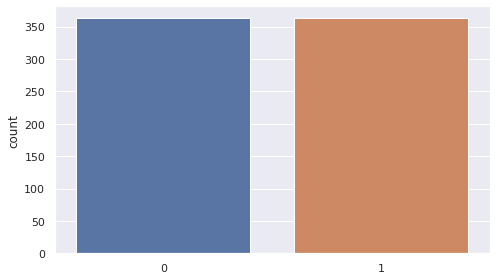

In [30]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# check the balanced data
print(pd.Series(y_rus).value_counts())

# plot the new distribution
fig, ax = plt.subplots(figsize=(7, 4))
ax = sns.countplot(y_rus)
plt.tight_layout()
plt.savefig('graph4.png')

Now we have balanced data, with 351 entries for each class.

##Classification Models
We are going to utilize two of the main machine learning classification methods:
*   Logistic Regression
*   Decision Tree

###Logistic Regression¶
Logistic regression models are used to determine the odds of a certain class or event existing. In our case, it will establish the probability of a transaction belonging to Class 0 or 1, which is regular or fraudulent.

In [31]:
model_log = LogisticRegression()

model_log.fit(X_rus, y_rus)

y_pred_log = model_log.predict(X_test)

Now let's evaluate the accuracy of our model using classification_report, roc_auc_score and confusion_matrix.

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71073
           1       0.06      0.89      0.11       129

    accuracy                           0.97     71202
   macro avg       0.53      0.93      0.55     71202
weighted avg       1.00      0.97      0.99     71202

AUC: 0.93



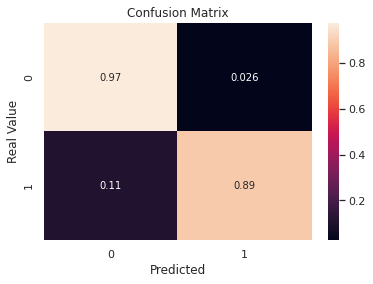

<Figure size 432x288 with 0 Axes>

In [32]:
# classification report
print(classification_report(y_test, y_pred_log))

# ROC AUC score
print("AUC: {:.2f}\n".format(roc_auc_score(y_test, y_pred_log)))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_log, normalize='true'), annot=True, ax=ax)

ax.set_title("Confusion Matrix")
ax.set_ylabel("Real Value")
ax.set_xlabel("Predicted")

plt.show()
plt.savefig('graph5.png')

Notice that the model has an accuracy of 97% and a ROC AUC score of 95%, meaning that our logistic regression performed really well.

From the confusion matrix, we can conclude that 97% of the regular transactions were correctly classified as regular (True Negatives) and 93% of the fraudulent transactions were accurately classified as frauds (True Positives).

##Decision Tree
We already saw that the logistic regression model performed well. Now let's see how the decision tree performs.

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     71073
           1       0.02      0.86      0.04       129

    accuracy                           0.92     71202
   macro avg       0.51      0.89      0.50     71202
weighted avg       1.00      0.92      0.96     71202

AUC: 0.89



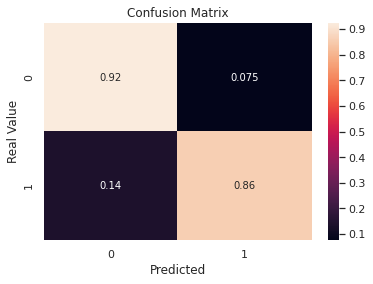

<Figure size 432x288 with 0 Axes>

In [33]:
model_tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")

model_tree.fit(X_rus, y_rus)

y_pred_tree = model_tree.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_tree))

# ROC AUC score
print("AUC: {:.2f}\n".format(roc_auc_score(y_test, y_pred_tree)))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_tree, normalize='true'), annot=True, ax=ax)

ax.set_title("Confusion Matrix")
ax.set_ylabel("Real Value")
ax.set_xlabel("Predicted")

plt.show()
plt.savefig('graph6.png')

The decision tree also performs quite well, with an accuracy of 97% and a ROC AUC score of 93%. The true positives and true negatives were well predicted, with 97% and 90%, respectively.

#Conclusion
Both models, Logistic Regression and Decision Tree performed extremely well in classifying credit card activities into the classes Regular Transaction and Fraudulent Transaction, with accuracy, ROC AUC scores and precision above 90%. Although they produced similar outcomes, the Logistic Regression showed slightly better results, with a greater ROC AUC score, which measures how well the model is capable to distinguish between classes.

It is important to point out how crucial it is to preprocess and balance the data. Remember how better the correlation matrix performed after the class data was balanced.

The machine learning algorithms for detecting credit card fraud are highly efficient, but there are still gaps to close. One of the biggest problems is the occurrence of False Positives, that is when the algorithm incorrectly detects a fraud. Thus, we are always searching for ways to shrink even more that 3% of False Positives.